# Linear Toffoli Gate Implementation QPT Benchmarking

In this document, we benchmark the performance of the pulse-optimized Toffoli gate.

In [1]:
# General Imports
from math import pi
from copy import deepcopy
import numpy as np
import time
from collections import defaultdict

In [2]:
# Qiskit-related Imports
import qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, transpile, execute
from qiskit.providers.aer import noise
from qiskit.compiler import assemble
from qiskit.circuit import Gate
from qiskit.result import Result
from qiskit import IBMQ
from qiskit.providers.ibmq.managed import IBMQJobManager

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter

from qiskit.quantum_info import Choi, Kraus, DensityMatrix
from qiskit.extensions import HGate, XGate

from qiskit import pulse
from qiskit.pulse.library import Gaussian

from qiskit.visualization import plot_state_city

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/superstaq/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  if sys.path[0] == '':


In [44]:
#error bar related import
import statistics
from error_bar import Montecarlo

Load IBM and Superstaq services.

In [4]:
IBMQ.load_account()
provider = IBMQ.providers()[1]
print(provider)
backend = provider.get_backend('ibmq_jakarta')
print(backend)

job_manager = IBMQJobManager()

<AccountProvider for IBMQ(hub='ibm-q-ornl', group='anl', project='csc430')>
ibmq_jakarta


In [5]:
basic_toffoli_circ = QuantumCircuit(3)
basic_toffoli_circ.ccx(0, 1, 2)

# Get the ideal Toffoli gate unitary operator
target_unitary = qi.Operator(basic_toffoli_circ)

In [6]:
qr = QuantumRegister(7)
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=[[0, 1, 3]], qr=qr, circlabel='mcal')

In [7]:
for circ in meas_calibs:
    print(circ.name)

mcalcal_000
mcalcal_001
mcalcal_010
mcalcal_011
mcalcal_100
mcalcal_101
mcalcal_110
mcalcal_111


In [8]:
meas_calibs[6].draw()

░ ┌─┐      
q0_0: ──────░─┤M├──────
      ┌───┐ ░ └╥┘┌─┐   
q0_1: ┤ X ├─░──╫─┤M├───
      └───┘ ░  ║ └╥┘   
q0_2: ──────░──╫──╫────
      ┌───┐ ░  ║  ║ ┌─┐
q0_3: ┤ X ├─░──╫──╫─┤M├
      └───┘ ░  ║  ║ └╥┘
q0_4: ──────░──╫──╫──╫─
            ░  ║  ║  ║ 
q0_5: ──────░──╫──╫──╫─
            ░  ║  ║  ║ 
q0_6: ──────░──╫──╫──╫─
            ░  ║  ║  ║ 
c0: 3/═════════╩══╩══╩═
               0  1  2

In [9]:
#meas_cal_job = execute(meas_calibs, backend=backend, optimization_level=0, shots=8192)  # uncomment to run

In [10]:
# meas_cal_job_id = meas_cal_job.job_id()
# meas_cal_job_id

In [11]:
meas_cal_job = backend.retrieve_job('61fb63feb09bcd2dd935b741') # calibration data

In [12]:
cal_results = meas_cal_job.result()

In [13]:
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=[[0, 1, 3]])

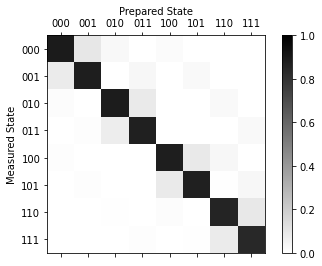

In [14]:
meas_fitter.plot_calibration(0)

In [15]:
print(meas_fitter.cal_matrices)

[array([[8.93432617e-01, 9.58251953e-02, 2.81982422e-02, 3.29589844e-03,
        1.85546875e-02, 2.19726562e-03, 6.10351562e-04, 0.00000000e+00],
       [8.09326172e-02, 8.82690430e-01, 2.92968750e-03, 3.30810547e-02,
        2.19726562e-03, 2.56347656e-02, 0.00000000e+00, 8.54492188e-04],
       [1.45263672e-02, 1.83105469e-03, 8.88671875e-01, 8.43505859e-02,
        1.22070312e-04, 0.00000000e+00, 2.50244141e-02, 1.83105469e-03],
       [1.09863281e-03, 9.64355469e-03, 7.22656250e-02, 8.68652344e-01,
        0.00000000e+00, 2.44140625e-04, 2.07519531e-03, 2.52685547e-02],
       [8.78906250e-03, 1.46484375e-03, 2.44140625e-04, 0.00000000e+00,
        8.79394531e-01, 8.85009766e-02, 3.32031250e-02, 3.41796875e-03],
       [9.76562500e-04, 8.54492188e-03, 0.00000000e+00, 7.32421875e-04,
        8.42285156e-02, 8.74877930e-01, 3.90625000e-03, 3.34472656e-02],
       [2.44140625e-04, 0.00000000e+00, 7.44628906e-03, 8.54492188e-04,
        1.39160156e-02, 8.54492188e-04, 8.55468750e-01, 9

In [16]:
meas_filter = meas_fitter.filter

Get truth table generation circuits

In [17]:
tt_cirq_0 = QuantumCircuit(7, 3)
tt_cirq_0.ccx(0, 1, 3)
tt_cirq_0.measure([0, 1, 3], [0, 1, 2])

tt_cirq_1 = QuantumCircuit(7, 3)
tt_cirq_1.x(0)
tt_cirq_1.ccx(0, 1, 3)
tt_cirq_1.measure([0, 1, 3], [0, 1, 2])

tt_cirq_2 = QuantumCircuit(7, 3)
tt_cirq_2.x(1)
tt_cirq_2.ccx(0, 1, 3)
tt_cirq_2.measure([0, 1, 3], [0, 1, 2])

tt_cirq_3 = QuantumCircuit(7, 3)
tt_cirq_3.x(0)
tt_cirq_3.x(1)
tt_cirq_3.ccx(0, 1, 3)
tt_cirq_3.measure([0, 1, 3], [0, 1, 2])

tt_cirq_4 = QuantumCircuit(7, 3)
tt_cirq_4.x(3)
tt_cirq_4.ccx(0, 1, 3)
tt_cirq_4.measure([0, 1, 3], [0, 1, 2])

tt_cirq_5 = QuantumCircuit(7, 3)
tt_cirq_5.x(0)
tt_cirq_5.x(3)
tt_cirq_5.ccx(0, 1, 3)
tt_cirq_5.measure([0, 1, 3], [0, 1, 2])

tt_cirq_6 = QuantumCircuit(7, 3)
tt_cirq_6.x(1)
tt_cirq_6.x(3)
tt_cirq_6.ccx(0, 1, 3)
tt_cirq_6.measure([0, 1, 3], [0, 1, 2])

tt_cirq_7 = QuantumCircuit(7, 3)
tt_cirq_7.x(0)
tt_cirq_7.x(1)
tt_cirq_7.x(3)
tt_cirq_7.ccx(0, 1, 3)
tt_cirq_7.measure([0, 1, 3], [0, 1, 2])

tt_cirqs = [tt_cirq_0, tt_cirq_1, tt_cirq_2, tt_cirq_3, tt_cirq_4, tt_cirq_5, tt_cirq_6, tt_cirq_7]

In [18]:
tt_cirq_6.draw()

┌─┐      
q_0: ───────■──┤M├──────
     ┌───┐  │  └╥┘┌─┐   
q_1: ┤ X ├──■───╫─┤M├───
     └───┘  │   ║ └╥┘   
q_2: ───────┼───╫──╫────
     ┌───┐┌─┴─┐ ║  ║ ┌─┐
q_3: ┤ X ├┤ X ├─╫──╫─┤M├
     └───┘└───┘ ║  ║ └╥┘
q_4: ───────────╫──╫──╫─
                ║  ║  ║ 
q_5: ───────────╫──╫──╫─
                ║  ║  ║ 
q_6: ───────────╫──╫──╫─
                ║  ║  ║ 
c: 3/═══════════╩══╩══╩═
                0  1  2

In [19]:
def drawTruthTable(results, shots=8192):
    counts = results.get_counts()
    mat_form = []
    for i in range(len(counts)):
        default_counts = defaultdict(lambda: 0, counts[i])
        col = [default_counts['000'], default_counts['001'], default_counts['010'], default_counts['011'], default_counts['100'], default_counts['101'], default_counts['110'], default_counts['111']]
        norm_col = [item / shots for item in col]
        print(f"Column {i}: {norm_col}")
        mat_form.append(norm_col)
    np_mat = np.matrix(mat_form, dtype=np.float64).T
    density_mat = DensityMatrix(np_mat)
    plot_state_city(density_mat)

## Baseline version specified with CNOT, H, T, and Tdag.

In [20]:
q0 = 0
q1 = 1
q2 = 3

with pulse.build(backend, name='canonical_toffoli') as canonical_toffoli_schedule:
    pulse.u3(pi/2, 0, pi, q2)  # Hadamard
    
    # T gates on qubits 0, 1, 2
    pulse.u3(0, 0, pi/4, q0)
    pulse.u3(0, 0, pi/4, q1)
    pulse.u3(0, 0, pi/4, q2)
    
    pulse.cx(q0, q1)
    pulse.cx(q1, q2)
    pulse.cx(q0, q1)
    
    pulse.u3(0, 0, pi/4, q2)
    
    pulse.cx(q1, q2)
    pulse.cx(q0, q1)
    
    pulse.u3(0, 0, -pi/4, q1)
    pulse.u3(0, 0, -pi/4, q2)

    pulse.cx(q1, q2)
    pulse.cx(q0, q1)
    
    pulse.u3(0, 0, -pi/4, q2)
    
    pulse.cx(q1, q2)

    pulse.u3(pi/2, 0, pi, q2)  # Hadamard

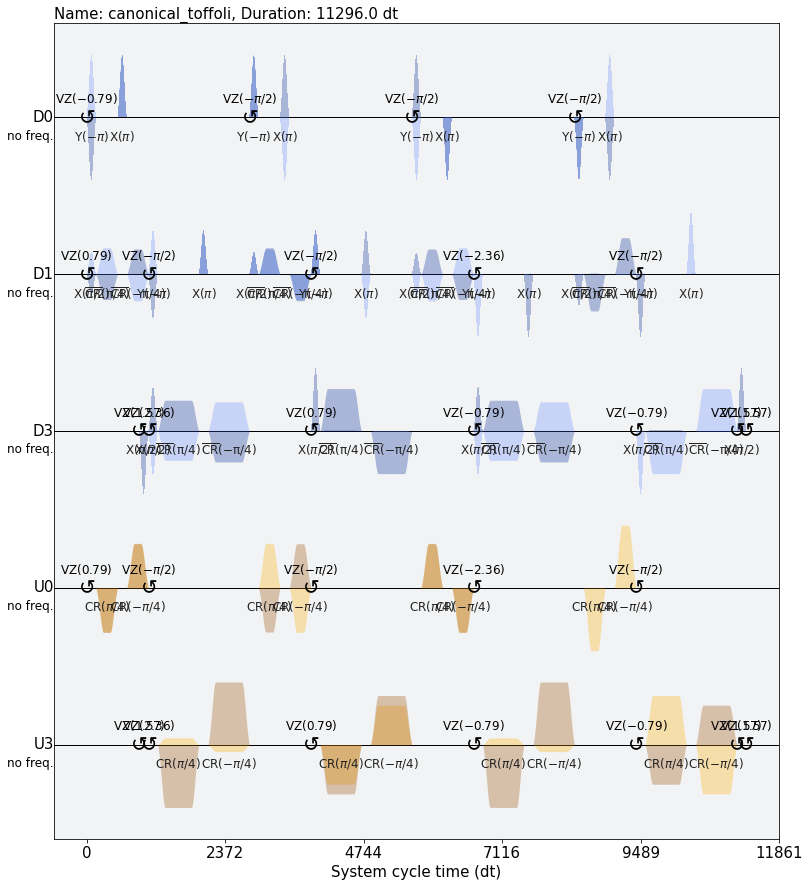

In [21]:
canonical_toffoli_schedule.draw()

In [22]:
lc_toffoli_c = QuantumCircuit(7)
lc_toffoli_c.ccx(0, 1, 3)

In [23]:
# Generate process tomography circuits and run on qasm simulator
lc_toffoli_c_cirqs = process_tomography_circuits(lc_toffoli_c, [0, 1, 3])

for circ in lc_toffoli_c_cirqs + tt_cirqs:
    circ.add_calibration('ccx', [0, 1, 3], canonical_toffoli_schedule)  # add pulse implementation of CCX to each Tomography circuit and truth table circuit

transpiled_lc_toffoli_c_cirqs = [transpile(circ, backend=backend) for circ in lc_toffoli_c_cirqs]
transpiled_tt_cirqs = [transpile(circ, backend=backend) for circ in tt_cirqs]

In [24]:
transpiled_lc_toffoli_c_cirqs[1024].draw()

global phase: π/4
         ┌─────────┐┌────┐┌─────────┐ ░       ░       ┌─┐                 
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░───■───░───────┤M├─────────────────
         └──┬───┬──┘└────┘└─────────┘ ░   │   ░       └╥┘┌─┐              
q_1 -> 1 ───┤ X ├─────────────────────░───■───░────────╫─┤M├──────────────
            └───┘                     ░   │   ░        ║ └╥┘              
q_2 -> 2 ─────────────────────────────░───┼───░────────╫──╫───────────────
            ┌───┐                     ░ ┌─┴─┐ ░ ┌────┐ ║  ║ ┌─────────┐┌─┐
q_3 -> 3 ───┤ X ├─────────────────────░─┤ X ├─░─┤ √X ├─╫──╫─┤ Rz(π/2) ├┤M├
            └───┘                     ░ └───┘ ░ └────┘ ║  ║ └─────────┘└╥┘
q_4 -> 4 ─────────────────────────────░───────░────────╫──╫─────────────╫─
                                      ░       ░        ║  ║             ║ 
q_5 -> 5 ─────────────────────────────░───────░────────╫──╫─────────────╫─
                                      ░       ░        ║  ║             ║ 
q_6 -> 6 ─────────────────────────────░───────░────────╫──╫─────────────╫─
                                      ░       ░        ║  ║             ║ 
   c1: 3/══════════════════════════════════════════════╩══╩═════════════╩═
                                                       0  1             2

In [25]:
transpiled_tt_cirqs[6].draw()

┌─┐      
q_0 -> 0 ───────■──┤M├──────
         ┌───┐  │  └╥┘┌─┐   
q_1 -> 1 ┤ X ├──■───╫─┤M├───
         └───┘  │   ║ └╥┘   
q_2 -> 2 ───────┼───╫──╫────
         ┌───┐┌─┴─┐ ║  ║ ┌─┐
q_3 -> 3 ┤ X ├┤ X ├─╫──╫─┤M├
         └───┘└───┘ ║  ║ └╥┘
q_4 -> 4 ───────────╫──╫──╫─
                    ║  ║  ║ 
q_5 -> 5 ───────────╫──╫──╫─
                    ║  ║  ║ 
q_6 -> 6 ───────────╫──╫──╫─
                    ║  ║  ║ 
    c: 3/═══════════╩══╩══╩═
                    0  1  2

In [42]:
#c_ccx_job = job_manager.run(transpiled_lc_toffoli_c_cirqs, backend=backend, name='ccx_c_benchmark_test_openpulse1015', shots=8192) # uncomment to run

In [43]:
# c_ccx_set_id = c_ccx_job.job_set_id()
# c_ccx_set_id

'ae0f5c7dfb89405cab714bc3a9c8f093-1643865153736238'

In [30]:
# Extract tomography data so that counts are indexed by measurement configuration
c_ccx_job = job_manager.retrieve_job_set(job_set_id='ae0f5c7dfb89405cab714bc3a9c8f093-1643865153736238', provider=provider)
c_ccx_job_result = c_ccx_job.results().combine_results()

In [31]:
mitigated_c_ccx_job_result = meas_filter.apply(c_ccx_job_result)

In [32]:
mitigated_c_ccx_job_result.get_counts()

[{'000': 1131.6530351530548,
  '001': 1165.2444295354994,
  '010': 662.5577931840098,
  '011': 738.1214322072808,
  '100': 1159.8532420744887,
  '101': 1257.405408511844,
  '110': 996.4215720078302,
  '111': 1080.7430873259925},
 {'000': 977.4514123987799,
  '001': 1070.9614451412726,
  '010': 662.3691272757102,
  '011': 695.3142718962754,
  '100': 1332.738300513921,
  '101': 1303.32974981093,
  '110': 960.5623683248167,
  '111': 1189.2733246382943},
 {'000': 2362.3518141877944,
  '001': 2378.8099769795035,
  '010': 1602.417305927046,
  '011': 1848.4209029066074,
  '110': 1.3412938836866728e-10},
 {'000': 784.8451362872381,
  '001': 912.8142801193878,
  '010': 995.0907479017243,
  '011': 1026.1041486714332,
  '100': 951.127426103597,
  '101': 925.8734637275846,
  '110': 1211.901862573335,
  '111': 1384.2429346156998},
 {'000': 644.6529182571938,
  '001': 748.2193793290819,
  '010': 1011.0583805081898,
  '011': 1022.6801673880776,
  '100': 1062.0956115759475,
  '101': 1035.0338458905792

Fidelity with Measurement Error Mitigation:

In [33]:
c_ccx_qpt_tomo = ProcessTomographyFitter(mitigated_c_ccx_job_result, transpiled_lc_toffoli_c_cirqs)

In [34]:
# Tomographic reconstruction of the canonical CCX operation
t = time.time()
c_ccx_choi_fit_lstsq = c_ccx_qpt_tomo.fit(method='lstsq')

print('Fit time:', time.time() - t)
fidelity_c_wm = qi.average_gate_fidelity(c_ccx_choi_fit_lstsq, target=target_unitary)
print('Average gate fidelity: F = {:.5f}'.format(fidelity_c_wm))

Fit time: 45.82384014129639
Average gate fidelity: F = 0.87720


Fidelity without Measurement Error Mitigation:

In [35]:
c_ccx_qpt_tomo_nomeas = ProcessTomographyFitter(c_ccx_job_result, transpiled_lc_toffoli_c_cirqs)

In [36]:
# Tomographic reconstruction of the canonical CCX operation
t = time.time()
c_ccx_choi_fit_lstsq_no_meas = c_ccx_qpt_tomo_nomeas.fit(method='lstsq')

print('Fit time:', time.time() - t)
fidelity_c_nm = qi.average_gate_fidelity(c_ccx_choi_fit_lstsq_no_meas, target=target_unitary)
print('Average gate fidelity: F = {:.5f}'.format(fidelity_c_nm))

Fit time: 47.4473340511322
Average gate fidelity: F = 0.76927


# Montecarlo Simulation based on Multinomial distribution

In [39]:
#generate 100 montecarlo simulation results, should change to 1000 in actual experiment.
trials = 100
fidelity_list = []

In [40]:
#simulating multinomial distribution based on the mitigated distribution from mitigated_c_ccx_job_result
for i in range(0, trials):
    mitigated_c_ccx_job_result_random = Montecarlo(mitigated_c_ccx_job_result)
    c_ccx_qpt_tomo_nomeas_random = ProcessTomographyFitter(mitigated_c_ccx_job_result_random, transpiled_lc_toffoli_c_cirqs)
    # Tomographic reconstruction of the canonical CCX operation
    c_ccx_choi_fit_lstsq_no_meas_random = c_ccx_qpt_tomo_nomeas_random.fit(method='lstsq')

    print('NO:', i)
    fidelity_mc = qi.average_gate_fidelity(c_ccx_choi_fit_lstsq_no_meas_random, target=target_unitary)
    print('Average gate fidelity: F = {:.5f}'.format(fidelity_mc))
    fidelity_list.append(fidelity_mc)

NO: 0
Average gate fidelity: F = 0.87558
NO: 1
Average gate fidelity: F = 0.87734
NO: 2
Average gate fidelity: F = 0.87609
NO: 3
Average gate fidelity: F = 0.87740
NO: 4
Average gate fidelity: F = 0.87627
NO: 5
Average gate fidelity: F = 0.87708
NO: 6
Average gate fidelity: F = 0.87699
NO: 7
Average gate fidelity: F = 0.87586
NO: 8
Average gate fidelity: F = 0.87554
NO: 9
Average gate fidelity: F = 0.87627
NO: 10
Average gate fidelity: F = 0.87748
NO: 11
Average gate fidelity: F = 0.87599
NO: 12
Average gate fidelity: F = 0.87648
NO: 13
Average gate fidelity: F = 0.87534
NO: 14
Average gate fidelity: F = 0.87682
NO: 15
Average gate fidelity: F = 0.87793
NO: 16
Average gate fidelity: F = 0.87668
NO: 17
Average gate fidelity: F = 0.87660
NO: 18
Average gate fidelity: F = 0.87544
NO: 19
Average gate fidelity: F = 0.87671
NO: 20
Average gate fidelity: F = 0.87702
NO: 21
Average gate fidelity: F = 0.87537
NO: 22
Average gate fidelity: F = 0.87671
NO: 23
Average gate fidelity: F = 0.87630
NO

In [42]:
print("The fidelity list : " + str(fidelity_list))

The fidelity list : [0.8755788414251833, 0.8773435477198828, 0.8760908210013012, 0.8773967015581956, 0.8762713293883855, 0.8770847345456727, 0.8769879677101573, 0.8758614785293171, 0.8755420257143697, 0.8762714077657585, 0.8774839781977507, 0.8759917316676711, 0.8764806939432123, 0.875341534433329, 0.8768222987332241, 0.877925219197891, 0.8766754924729724, 0.8766012219005105, 0.8754375326843342, 0.8767067108006372, 0.8770193015678739, 0.8753746149454216, 0.8767121019861148, 0.8762985625286195, 0.8776319344993979, 0.8767902768543144, 0.8764775758468639, 0.8757334416851758, 0.8757220779497418, 0.8770017967348471, 0.8769274508297874, 0.8765749302376913, 0.8762127055664332, 0.876001858514068, 0.8761082378360345, 0.8762831867224308, 0.8751538896843546, 0.8755681587406191, 0.8749962347652974, 0.8761428210854008, 0.8766743632427346, 0.8770974743365271, 0.8767805415754292, 0.8764405586080967, 0.87642194012792, 0.8764284005390102, 0.8749862191853357, 0.8767854366896493, 0.8763638147288836, 0.87

In [45]:
# Calculate Standard deviation of the fidelity list Using pstdev()
fidelity_stdev = statistics.pstdev(fidelity_list)
print('standard deviation: {:.5f}, 95%error bar:{:.5f}'.format(fidelity_stdev, 1.96*fidelity_stdev))

standard deviation: 0.00070, 95%error bar:0.00137
